In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

We will limit our data to the country **USA**:

In [31]:
def dataframeByRegion(df, region):
    return df[df['region'] == region]

In [32]:
spotify_data = pd.read_csv("../data/spotify_2020+_cleaned.csv")
spotify_data["date"] = pd.to_datetime(spotify_data["date"])
us_data = dataframeByRegion(spotify_data, "United States")
us_data.dtypes

Unnamed: 0             int64
title                 object
rank                   int64
date          datetime64[ns]
artist                object
region                object
chart                 object
trend                 object
dtype: object

first, lets check if a song title is aviable both in **top200** and **viral50** charts:

In [33]:
def find_valid_songs(my_data): # returns a list of songs which appear both in top200 and viral50 charts
    data_by_title = my_data.groupby("title")
    usable_titles = []
    for (name,group) in data_by_title.__iter__():
        if ("viral50" in group["chart"].unique() ) and ("top200" in group["chart"].unique()):
            usable_titles.append(name)
    usable_titles = pd.Series(usable_titles)
    num_title = len(us_data["title"].unique())
    print(f" titles which appear in both charts: {usable_titles.count()}\n total number of titles: {num_title}")
    return usable_titles


In [34]:
usable_titles = find_valid_songs(us_data)
usable_title_df = us_data[us_data["title"].isin(usable_titles)]
usable_title_df["title"].count()

 titles which appear in both charts: 747
 total number of titles: 4887


89136

Next, we create two dataframes for our different charts: **Viral50** and **Top200**

In [35]:
viral_50 = usable_title_df[usable_title_df["chart"] == "viral50"]
viral_50.shape

(17114, 8)

In [36]:
viral_50.head()

,Unnamed: 0,title,rank,date,artist,region,chart,trend
10961711,10961711,GOODMORNINGTOKYO!,1,2020-01-01,TOKYO’S REVENGE,United States,viral50,SAME_POSITION
10961713,10961713,"All I Want - From ""High School Musical: The Mu...",2,2020-01-01,Olivia Rodrigo,United States,viral50,SAME_POSITION
10961715,10961715,Blueberry Faygo,3,2020-01-01,Mikey.Otx,United States,viral50,MOVE_UP
10961717,10961717,The Box,4,2020-01-01,Roddy Ricch,United States,viral50,MOVE_DOWN
10961721,10961721,No Idea,6,2020-01-01,Don Toliver,United States,viral50,SAME_POSITION


In [37]:
top_200 = usable_title_df[usable_title_df["chart"] == "top200"]
top_200.shape

(72022, 8)

In order to plot viral rank vs top 200 rank, we need to create a new dataframe:

In [38]:
def get_rank_title_df(titles, viral_50, top_200): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    viral_ranks = []
    top_200_ranks = []
    titles = titles.tolist()
    for my_title in titles:
        viral_rank = viral_50.loc[viral_50["title"] == my_title, ["rank"]].mean()[0]
        viral_ranks.append(viral_rank)
        top_200_rank = top_200.loc[top_200["title"] == my_title, ["rank"]].mean()[0]
        top_200_ranks.append(top_200_rank)
    df = pd.DataFrame(
        {
            "viral_50_rank_mean" : viral_ranks,
            "top_200_rank_mean" : top_200_ranks,
            "title": titles
        }
    )
    return df

In [39]:
rank_title_df = get_rank_title_df(usable_titles, viral_50 = viral_50, top_200 = top_200)
rank_title_df.sample(10)

,viral_50_rank_mean,top_200_rank_mean,title
716,35.285714,127.096774,forget me too (feat. Halsey)
633,43.571429,124.612903,Volando - Remix
186,46.200000,74.428571,Eleven
717,20.500000,10.852174,good 4 u
192,49.000000,188.000000,Estos Celos
46,38.666667,130.571429,Angels Like You
160,15.323077,79.388235,Deep End Freestyle
124,34.125000,101.351020,Chicago Freestyle (feat. Giveon)
508,9.355556,90.803571,SAD GIRLZ LUV MONEY Remix (feat. Kali Uchis an...
624,37.285714,21.833333,Turks (feat. Travis Scott)


## Plotting mean of ranks against each other:
for the entire two years which our spotify data covers

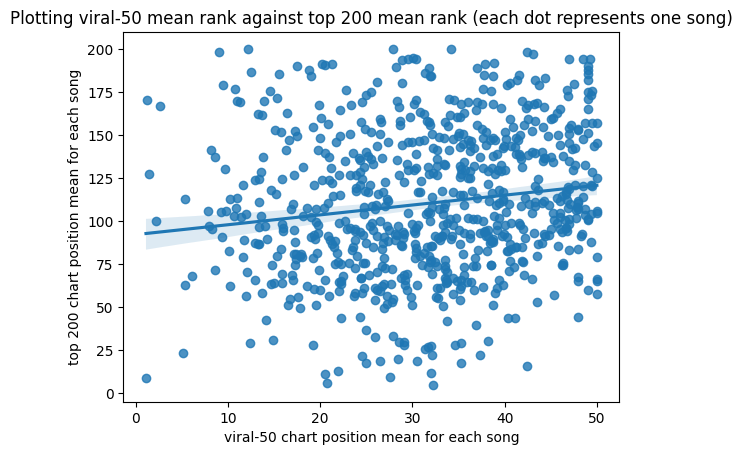

In [40]:
sns.regplot(data=rank_title_df, x = "viral_50_rank_mean", y = "top_200_rank_mean")
plt.title("Plotting viral-50 mean rank against top 200 mean rank (each dot represents one song)")
plt.xlabel("viral-50 chart position mean for each song")
plt.ylabel("top 200 chart position mean for each song")
plt.show()

In [41]:
rank_title_df.corr(method="pearson",numeric_only=True)

,viral_50_rank_mean,top_200_rank_mean
viral_50_rank_mean,1.000000,0.152003
top_200_rank_mean,0.152003,1.000000


As we can see, the viral50 and top 200 ranks are only very weakly correlated. This means that a linear regression model will not suffice to use predict the top200 charts from our viral 50 charts.

## Plotting ranks against each other for selected weeks within our dataframe: 

In [42]:
def get_rank_title_per_week_df(titles, viral_50, top_200, curr_date = "2020-01-05", delta = 7): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=delta) # date of next week
    viral_ranks = []
    top_200_ranks = []
    title_keys = []
    dates_viral = []
    dates_top200 = []
    trends = []
    for my_title in titles:
        #print(f"list lengths: viral_ranks length: {len(viral_ranks)}\n top_200 length: {len(top_200_ranks)}\n titles length: {len(titles)}")
        viral_rank = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["rank"]]
        trend = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["trend"]]
        if viral_rank.empty:
            #print(f"Error couldnt retrieve viral50 rank for title {my_title}")
            pass
        else:
            viral_ranks.append(viral_rank.iloc[0]["rank"]) # this is a dataframe which should only contain 1 value, we extract it with iloc
            trends.append(trend.iloc[0]["trend"])
            top_200_rank = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next), ["rank"]]
            if top_200_rank.empty:
                #print(f"Error couldnt retrieve top200 rank for title {my_title}")
                # fix viral data entry so length is the same because there is no top200 rank for this viral rank
                if  len(viral_ranks) > 0:
                    viral_ranks.pop()
                    trends.pop()
            else:
                top_200_ranks.append(top_200_rank.iloc[0]["rank"])# this is a dataframe which should only contain 1 value, we extract it with iloc
                title_keys.append(my_title)
    for x in title_keys: # add a  start and end date entry to each title found in week timespan, so that the arrays match
        dates_viral.append(date_current) #date of viral 50 rank retrieval
        dates_top200.append(date_next) # date of top 200 rank retrieval
    df = pd.DataFrame(
        {
            "title": title_keys,
            "date_viral" : dates_viral,
            "viral_50_rank" : viral_ranks,
            "date_top200" : dates_top200,
            "top_200_rank" : top_200_ranks,
            "trend" : trends
        }
    )
    return df

In [43]:
# write data to csv for prediction step
list_df = []
dates_pred = pd.date_range(start="2020-01-01", end = "2021-12-31", freq = "W")
for my_date in dates_pred:
        list_df.append(get_rank_title_per_week_df(usable_titles, viral_50 = viral_50, top_200 = top_200, curr_date=my_date, delta=7))
    

In [44]:
df_pred = pd.concat(list_df)
df_pred.sample(10)

,title,date_viral,viral_50_rank,date_top200,top_200_rank,trend
4,Get Into It (Yuh),2021-08-29,43.0,2021-09-05,44.0,MOVE_DOWN
8,Pepas,2021-08-01,12.0,2021-08-08,42.0,MOVE_UP
0,2055,2021-08-01,39.0,2021-08-08,13.0,MOVE_UP
6,Selfish,2020-04-26,39.0,2020-05-03,81.0,SAME_POSITION
0,Daisy,2020-10-11,17.0,2020-10-18,42.0,MOVE_DOWN
10,Hold On,2021-04-04,37.0,2021-04-11,29.0,MOVE_DOWN
3,Break My Stride,2020-01-26,6.0,2020-02-02,197.0,SAME_POSITION
3,Ballin' (with Roddy Ricch),2020-01-05,38.0,2020-01-12,13.0,SAME_POSITION
12,t r a n s p a r e n t s o u l feat. Travis Barker,2021-07-18,31.0,2021-07-25,34.0,MOVE_DOWN
13,edamame (feat. Rich Brian),2021-09-26,23.0,2021-10-03,145.0,SAME_POSITION


In [45]:
df_pred.to_csv("../data/weekly_ranks_with_trends.csv")

just to be sure, lets do the same plot for one **week**: we check the viral50 charts of the current day and see if they correlate with the top200 charts 7 days later:

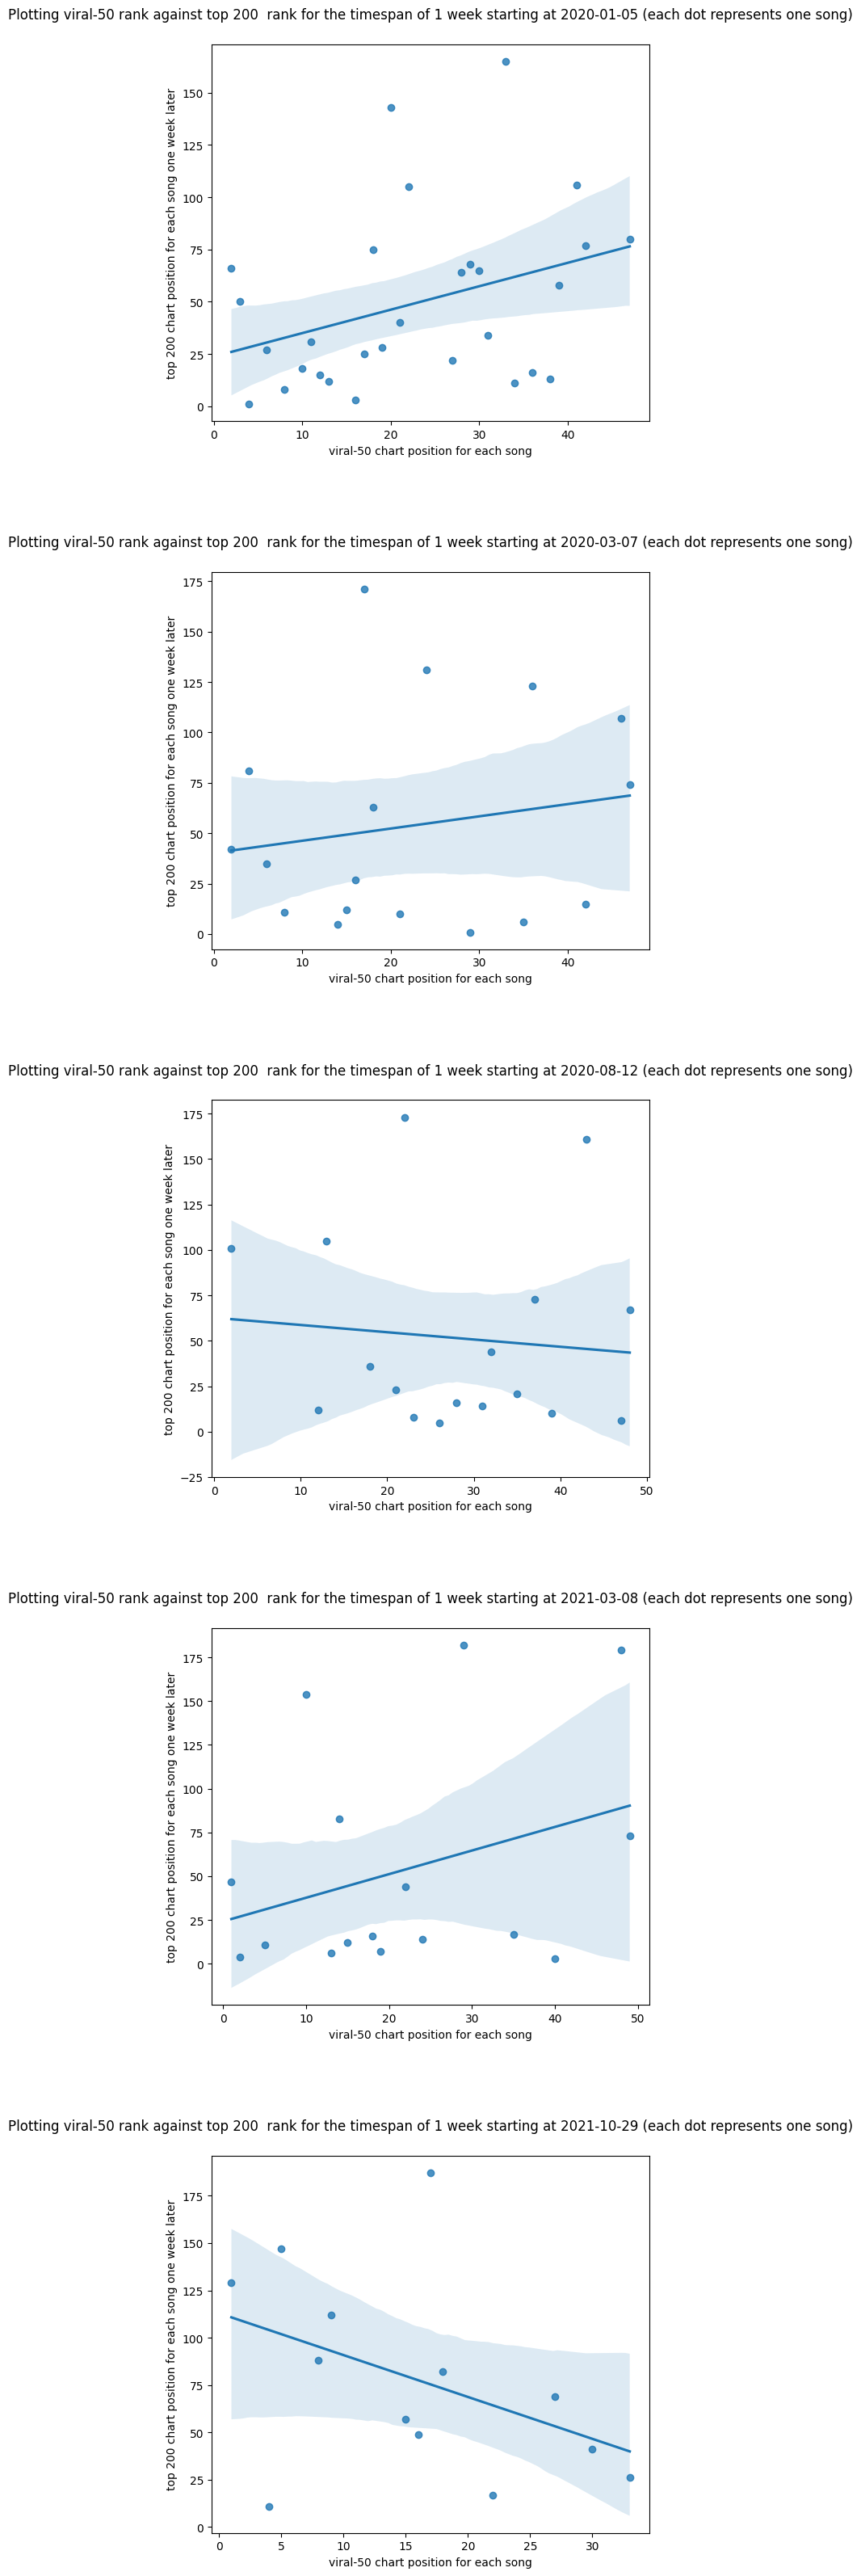

In [46]:
fig, ax = plt.subplots(5,figsize=(7,40))
plt.subplots_adjust(hspace=0.4)
for i, date in enumerate(rank_title_week):
    sns.regplot(data=rank_title_week[date], x = "viral_50_rank", y = "top_200_rank", ax=ax[i])
    ax[i].set_title(f"Plotting viral-50 rank against top 200  rank for the timespan of 1 week starting at {date} (each dot represents one song)",y=1.05)
    ax[i].set_xlabel("viral-50 chart position for each song")
    ax[i].set_ylabel("top 200 chart position for each song one week later")
fig.show()

In [47]:
for my_date, my_df in rank_title_week.items():
    print(f"correlation for week starting at: {date}")
    print(my_df.corr(method="pearson", numeric_only=True))

correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.349135
top_200_rank        0.349135      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.167547
top_200_rank        0.167547      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.094732
top_200_rank       -0.094732      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.320267
top_200_rank        0.320267      1.000000
correlation for week starting at: 2021-10-29
               viral_50_rank  top_200_rank
viral_50_rank        1.00000      -0.42335
top_200_rank        -0.42335       1.00000


We can see that depending on which week we pick, the correlation can be very different. This further supports our discovery from the mean plot.
A possible different approach for our final project could be to look at the **change in rank** instead of the rank itself; if a song moves up in rank over a certain period within the viral50 chart, that could indicate a higher rank in the top 200 chart.